<h1><center>W281 Final Project: Galaxy Zoo Classification</center></h1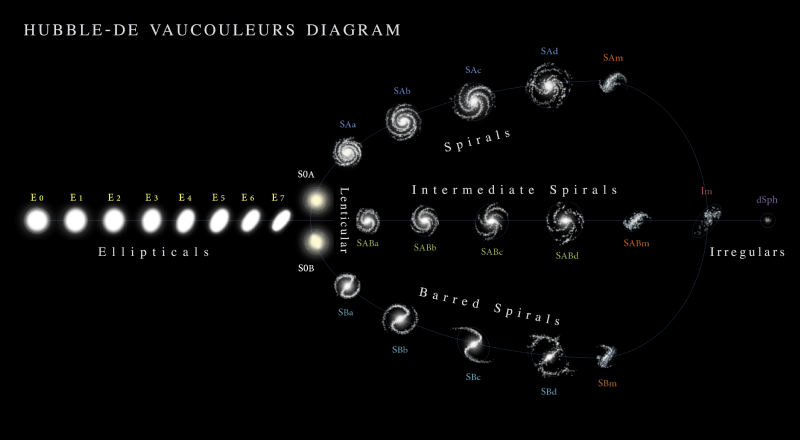>
<h3><center>Ryan Chen, Immanuel Abdi, Qichen Liu</center></h3>

# 0 Imports

(Run the following cell only when you're running this notebook in Colab.)

In [1]:
from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from random import sample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import cv2
from skimage import exposure, feature
from skimage.color import rgb2gray
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 1 Problem Definition

## 1.1 Problem Background

Many people love observing stars in the sky. As neural network technology becomes increasingly mature and popular in recent years, astronomy scientists and amateurs are able to investigate astronomical objects more deeply.

## 1.2 Problem Motivation

There are countless stars above our heads and each of them can have various differing morphologies that are arduous to manually classify due to the complexity of stars. As a result, an automatic method for identifying and tagging astronomical objects is needed.

Thus, our team is aiming for astronomical object classification. We seek to address this by using classical and machine learning computer vision
methodologies to classify galaxies.

## 1.3 Dataset Description

[Galaxy Zoo 1 dataset](https://www.kaggle.com/datasets/anjosut/galaxy-zoo-classification) is produced by [Galaxy Zoo project](https://data.galaxyzoo.org/) from July 2007 until February 2009, where volunteers classified images of Sloan Digital Sky Survey (SDSS) galaxies as belonging to one of five categories below.

1. **Cigar-Shaped Smooth**: Galaxies that appear elongated and smooth without distinct features like spiral arms or a disk visible.
2. **In-between Smooth**: Galaxies that do not fit neatly into the completely round or cigar-shaped categories and have a smooth appearance without clear features.
3. **Complete Round Smooth**: Galaxies that appear completely round and smooth, with no visible features such as spiral arms or disk.
4. **Edge-on**: Galaxies viewed from the side, making their disk visible as a thin line or edge, often obscuring detailed features.
5. **Spiral**: Galaxies with visible spiral arms winding out from the center, often with a bulge at the center.

For a more detailed principle of galaxy classification, please refer to Hubble - de Vaucouleurs Galaxy Morphology Diagram:

![jupyter](https://upload.wikimedia.org/wikipedia/commons/thumb/8/85/Hubble_-_de_Vaucouleurs_Galaxy_Morphology_Diagram.png/800px-Hubble_-_de_Vaucouleurs_Galaxy_Morphology_Diagram.png)

The dataset was preprocessed by [Lintott et al. 2008, MNRAS, 389, 1179](https://ui.adsabs.harvard.edu/abs/2008MNRAS.389.1179L/abstract). All of the 28,793 images were corrected with redshifts and astronomical objects were centered. They all have size 424 x 424 and a resolution of 96 dpi. They are now avaibale on Kaggle.

### 1.3.1 Images

Image examples of the five galaxy categories are shown as below.

In [3]:
def display_images(imgs, n_samples=3, is_gray=True, suptitle=''):
    """
    Plot the images
    """
    # Create figure
    n_categories = len(imgs)
    fig, axes = plt.subplots(nrows=n_samples, ncols=n_categories, figsize=(20, 10))

    for i, item in enumerate(imgs.items()):
        category, img_list = item
        for j, img in enumerate(img_list):
            # Ensure output image is scaled between [0,1]
            img = ((img - np.min(img)) / (np.max(img) - np.min(img)))
            if is_gray:
                axes[j, i].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
            else:
                axes[j, i].imshow(img, vmin=0, vmax=1)
            axes[j, i].set_axis_off()
            if j == 0:
                axes[j, i].set_title(category.title())
    if suptitle:
        plt.suptitle(suptitle)
    fig.tight_layout()
    plt.show()

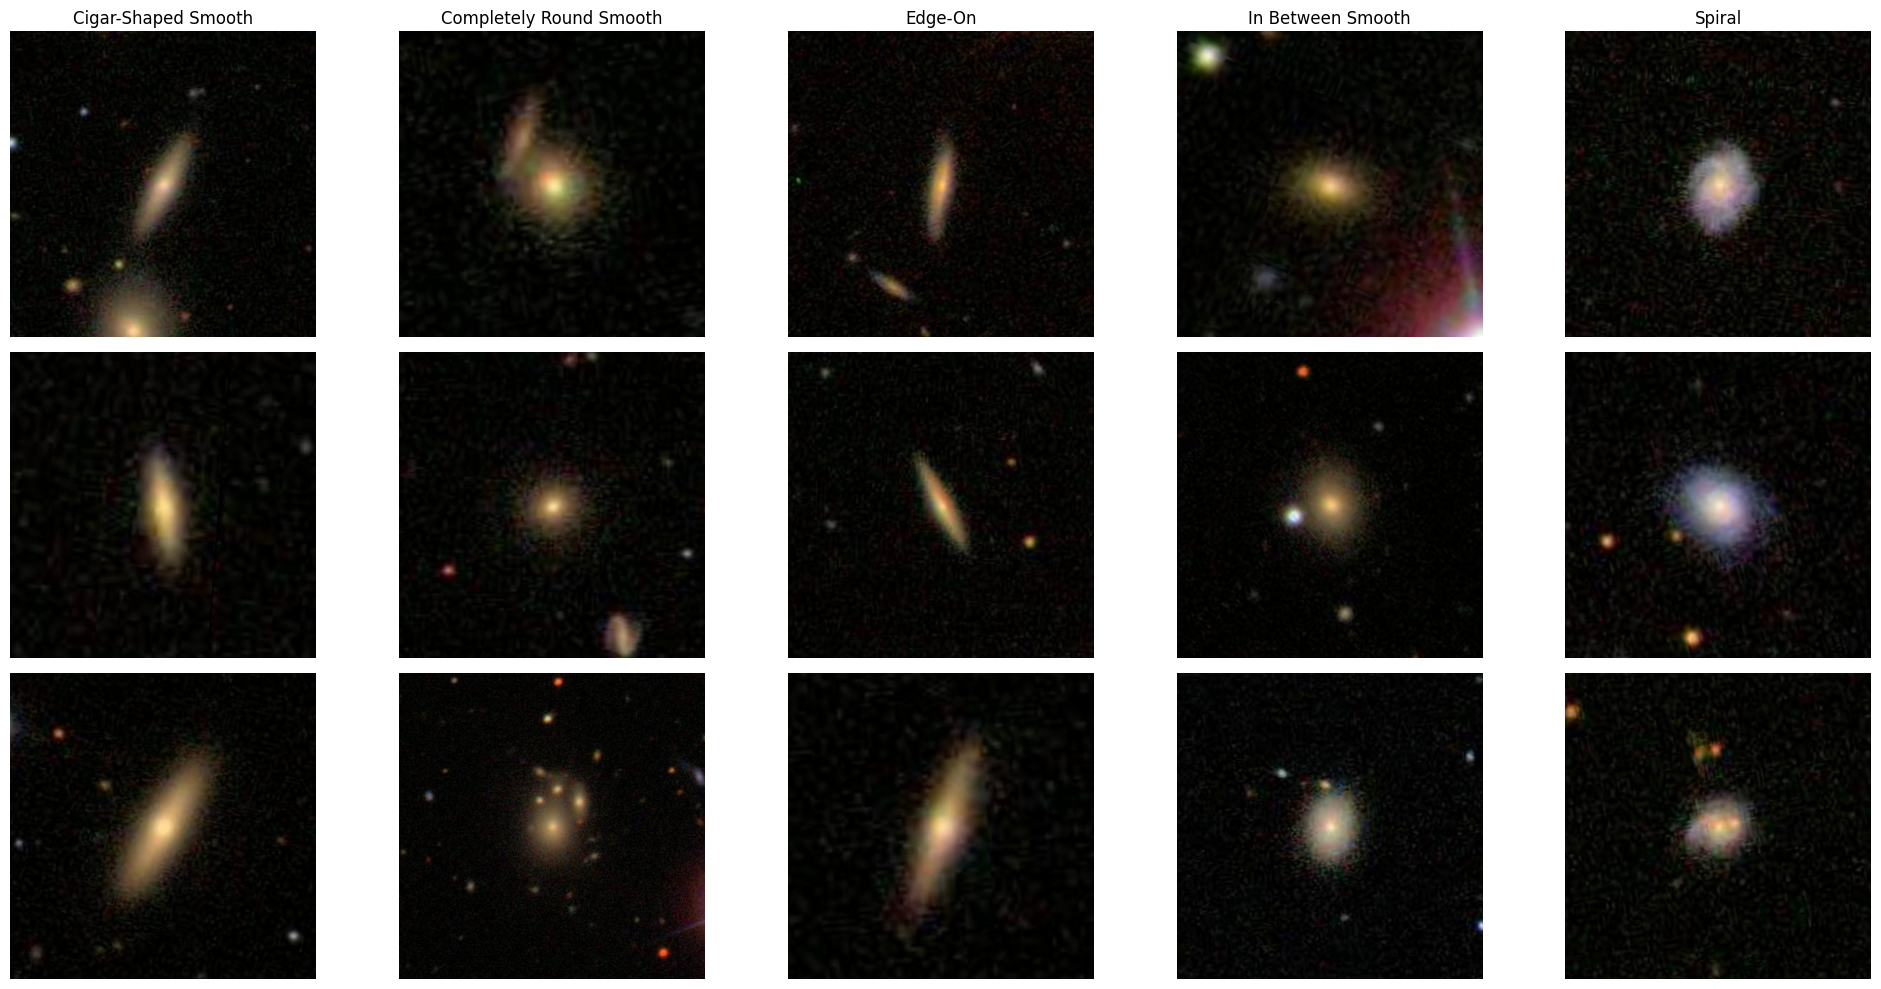

In [4]:
image_dir = '/content/drive/MyDrive/W281/Train_images' # PLEASE CHANGE THIS PATH ACCORDINGLY
categories = os.listdir(image_dir)

example_imgs = {}
example_files = {}
for category in categories:
    example_imgs[category] = []
    example_files[category] = []
    category_dir = os.path.join(image_dir, category)
    image_files = os.listdir(category_dir)
    for file in sample(image_files, 3):
        path = os.path.join(category_dir, file)
        example_files[category].append(path)
        example_imgs[category].append(plt.imread(path))

display_images(example_imgs, 3, False)

#### Exploratory Data Analysis

The number of images in each category is described as follows.

In [5]:
for category in categories:
    category_path = os.path.join(image_dir, category)
    image_files = os.listdir(category_path)
    image_files = [f for f in image_files if '(1)' not in f] # Delete it for local running
    print(f'{category.title()}: {len(image_files)}')

Cigar-Shaped Smooth: 579
Completely Round Smooth: 8436
Edge-On: 3903
In Between Smooth: 8069
Spiral: 7806


### 1.3.2 Labels

This CSV file provides information of labels (categories). Each row contains an index of an image and its category.

In [6]:
csv_file = '/content/drive/MyDrive/W281/train_label.csv'  # PLEASE CHANGE THIS PATH ACCORDINGLY
label_df = pd.read_csv(csv_file, names=['index', 'class'])
display(label_df)

index   class
0      100053  Class1
1      100122  Class1
2      100143  Class3
3      100288  Class1
4      100295  Class1
...       ...     ...
28788  999777  Class4
28789  999875  Class4
28790  999890  Class3
28791  999964  Class4
28792  999967  Class1

[28793 rows x 2 columns]

# 2 Data Preprocessing

## 2.1 Path Information

In [7]:
def path_generator(dir):
    files = os.listdir(dir)
    files = [f for f in files if '(1)' not in f] # Delete it for local running
    df = pd.DataFrame({'files': files})
    df['index'] = df['files'].apply(lambda s: int(s.split('.')[0]))
    df['path'] = df['files'].apply(lambda s: os.path.join(dir, s))
    return df[['index', 'path']]

path_df_list = []
for category in categories:
    category_dir = os.path.join(image_dir, category)
    path_df_list.append(path_generator(category_dir))
path_df = pd.concat(path_df_list, ignore_index=True)
df = path_df.merge(label_df, on='index')
df

index                                               path   class
0      396279  /content/drive/MyDrive/W281/Train_images/Cigar...  Class0
1      201198  /content/drive/MyDrive/W281/Train_images/Cigar...  Class0
2      157311  /content/drive/MyDrive/W281/Train_images/Cigar...  Class0
3      388918  /content/drive/MyDrive/W281/Train_images/Cigar...  Class0
4      487287  /content/drive/MyDrive/W281/Train_images/Cigar...  Class0
...       ...                                                ...     ...
28788  212161  /content/drive/MyDrive/W281/Train_images/spira...  Class4
28789  233081  /content/drive/MyDrive/W281/Train_images/spira...  Class4
28790  192806  /content/drive/MyDrive/W281/Train_images/spira...  Class4
28791  304328  /content/drive/MyDrive/W281/Train_images/spira...  Class4
28792  285730  /content/drive/MyDrive/W281/Train_images/spira...  Class4

[28793 rows x 3 columns]

## 2.2 Data Split

We divide our dataset with a ratio of 0.8, 0.1, and 0.1 for training, validation, and testing respectively.

In [8]:
def data_split(df):
    # training, validation, testing: 0.8, 0.1, 0.1
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    return train_df, val_df, test_df

## 2.3 Image Preprocessing

Image Blurring refers to making the image less clear or distinct. It is done with the help of various low pass filter kernels. Advantages of blurring:
- It helps in Noise removal. As noise is considered as high pass signal so by the application of low pass filter kernel we restrict noise.
- It helps in smoothing the image.
Low intensity edges are removed.
- It helps in hiding the details when necessary. For e.g. in many cases police deliberately want to hide the face of the victim, in such cases blurring is required.

Gaussian Blurring: Gaussian blur is the result of blurring an image by a Gaussian function. It is a widely used effect in graphics software, typically to reduce image noise and reduce detail. It is also used as a preprocessing stage before applying our machine learning or deep learning models.

Bilateral Blur: A bilateral filter is a non-linear, edge-preserving, and noise-reducing smoothing filter for images. It replaces the intensity of each pixel with a weighted average of intensity values from nearby pixels. This weight can be based on a Gaussian distribution. Thus, sharp edges are preserved while discarding the weak ones.

In [9]:
class GalaxyImage:
    def __init__(self, image_file):
        # read image
        self.img = plt.imread(image_file)
        # convert to floating point image with intensity [0, 1]
        if np.max(self.img) > 1:
            self.img = self.img.astype(np.float32) / 255.0
        # convert to grayscale
        if len(self.img.shape) > 2:
            self.img = rgb2gray(self.img)
        # create clipped image
        self.clipped_image = self.img.copy()

    def contrast_stretching(self):
        # get min and max
        min_v = np.min(self.img)
        max_v = np.max(self.img)
        # rescale intensity to min/max range
        self.img = exposure.rescale_intensity(self.img, in_range=(min_v, max_v))
        return self.img

    def histogram_clipping(self, threshold):
        # normalize the clipped_image to 0-255 for proper histogram visualization
        self.clipped_image[self.clipped_image < threshold/255.0] = 0
        self.clipped_image = cv2.normalize(self.clipped_image, None, alpha=0, beta=255,
                                           norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        return self.clipped_image

    def gaussian_blur(self, kernel_size, sigma):
        self.clipped_image = cv2.GaussianBlur(self.clipped_image, kernel_size, sigmaX=sigma[0], sigmaY=sigma[1])
        return self.clipped_image

    def bilateral_blur(self, kernel_size, sigma_color, sigma_space):
        self.clipped_image = cv2.bilateralFilter(self.img, kernel_size, sigma_color, sigma_space)
        return self.clipped_image

    def sobel_filter(self, kernel_size):
        # find x and y gradients
        sobelx = cv2.Sobel(self.clipped_image, cv2.CV_32F, 1, 0, ksize=kernel_size)
        sobely = cv2.Sobel(self.clipped_image, cv2.CV_32F, 0, 1, ksize=kernel_size)
        magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
        # normalize
        magnitude = magnitude / np.max(magnitude)
        return magnitude

    def canny_filter(self, img, low_threshold, high_threshold):
        # ensure the image is normalized to the range [0, 1]
        img = img / np.max(img)
        # scale the image to the range [0, 255] and convert to 8-bit
        img_8u = np.uint8(img * 255)
        # threshold the image and get the interesting points
        # The high threshold is used to identify the strong edges. Pixels with intensity gradients above this threshold are marked as strong edge pixels.
        # The low threshold is used to identify the non-edges. Pixels with intensity gradients below this threshold are suppressed.
        # By setting the high threshold too low, many pixels might be considered as strong edges, leading to a noisy edge image. Similarly, if the low threshold is set too high, you might miss genuine weak edges that should contribute to the final edge image.

        im_threshold = cv2.Canny(image=img_8u, threshold1=low_threshold, threshold2=high_threshold) # Canny Edge
        im_threshold = im_threshold / np.max(im_threshold) # normalize
        return im_threshold

    def hog(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm = 'L1'):
        # Block normalization method
        # orientations = 9   # Number of orientation bins
        # pixels_per_cell = (8, 8)  # Size of the cell
        # cells_per_block = (3, 3)  # Size of the block

        # Compute the HOG features
        hog_features, hog_image = feature.hog(self.clipped_image,
                                              orientations=orientations,
                                              pixels_per_cell=pixels_per_cell,
                                              cells_per_block=cells_per_block,
                                              block_norm=block_norm,
                                              visualize=True)
        return hog_image

    def crop_center(self, img, cropx, cropy):
        y, x = img.shape
        startx = x // 2 - (cropx // 2)
        starty = y // 2 - (cropy // 2)
        return img[starty:starty+cropy, startx:startx+cropx]

    def preprocessing(self):
        self.contrast_stretching()
        self.histogram_clipping(30)
        self.gaussian_blur((9, 9), (10, 10))
        self.bilateral_blur(5, 30, 30)

    def pipeline_1(self):
        img = self.sobel_filter(31)
        img = self.canny_filter(img, 0, 70)
        img = self.crop_center(img, 250, 250)
        return img

    def pipeline_2(self):
        img = self.hog()
        img = self.crop_center(img, 250, 250)
        return img

    # display the image with its colorbar
    def display_img_colorbar(self):
        # display the points
        fig, ax = plt.subplots(figsize=(15, 10))
        im_ax = plt.imshow(self.img, cmap='gray')
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im_ax, cax=cax)
        plt.show()

In [10]:
example_feature_1 = {}
example_feature_2 = {}

for category in categories:
    example_feature_1[category] = []
    example_feature_2[category] = []
    for path in example_files[category]:
        img = GalaxyImage(path)
        img.preprocessing()
        example_feature_1[category].append(img.pipeline_1())
        example_feature_2[category].append(img.pipeline_2())

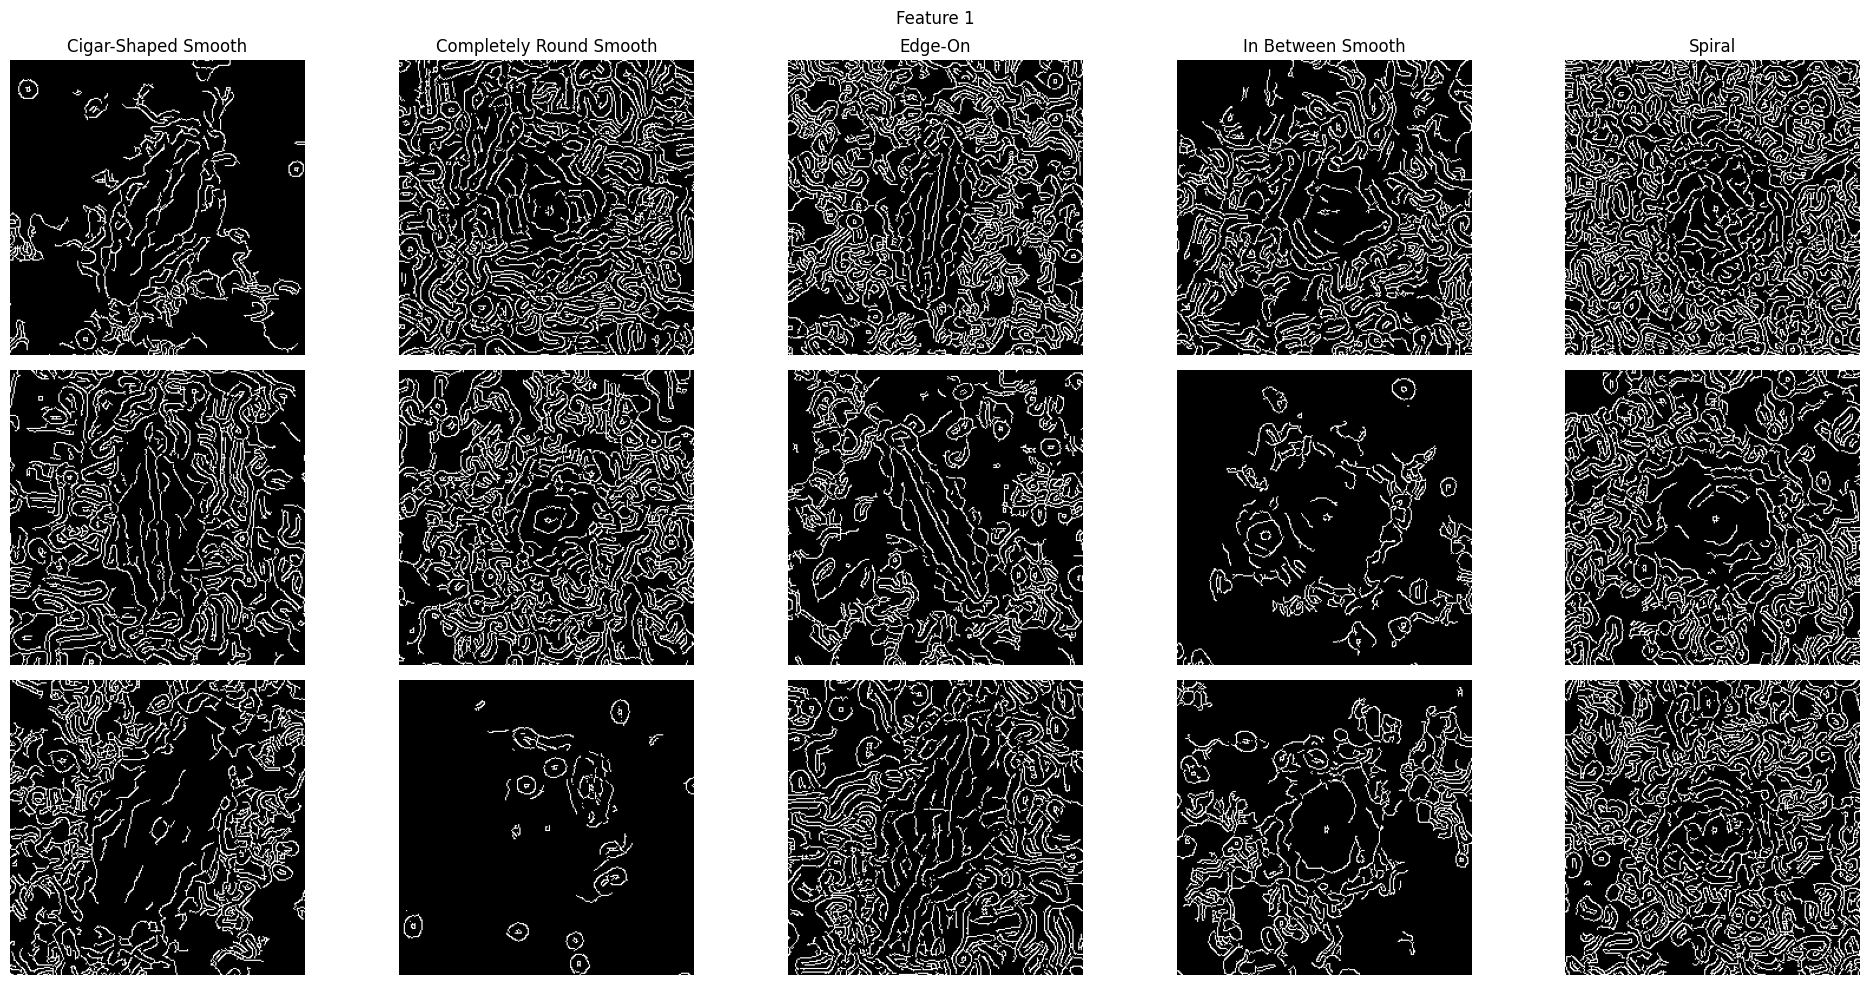

In [11]:
display_images(example_feature_1, 3, suptitle='Feature 1')

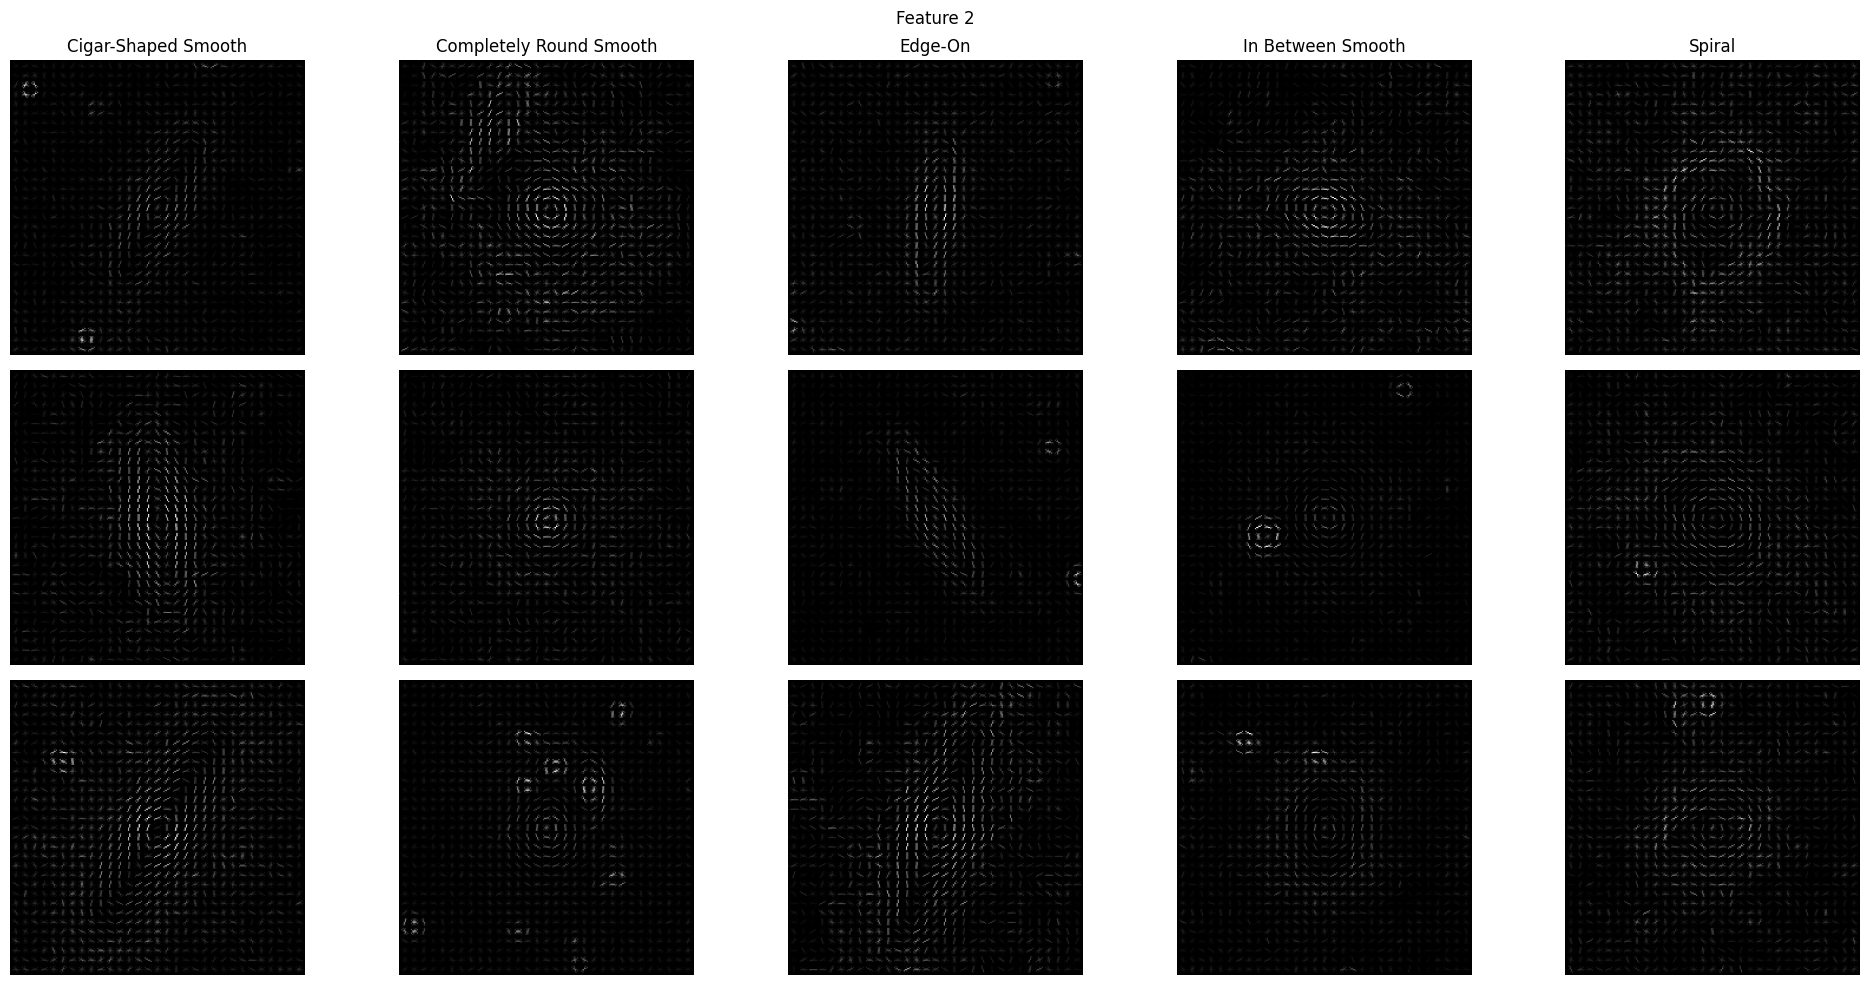

In [12]:
display_images(example_feature_2, 3, suptitle='Feature 2')

In [13]:
# img1 = GalaxyImage(os.path.join(image_path, image_file))
# img1.preprocessing()
# img1.display_img_colorbar()

# feature_1 = img1.pipeline_1()
# feature_2 = img1.pipeline_2()

# plt.imshow(feature_1)
# # plt.axis('off')
# plt.show()

# plt.imshow(feature_2)
# # plt.axis('off')
# plt.show()